```text
使用python解决一个旅行商问题，要求将路径规划函数与绘图函数解耦。先进行路径规划再进行绘图
在大小为a*b的地图中随机生成n个节点,节点生成时不需要考虑参数d。
使用边长为d的六边形呈蜂窝状覆盖地图，在GUI界面中绘制蜂窝图以及节点，找到并使用其他颜色绘制含有节点的区域。
路径规划算法应以六边形为单位，旅行商从(0,0)所在的六边形出发，到(a,b)所在的六边形结束。每次行动从当前六边形中心前往相邻的六个六边形中心之一，每个单位可以被访多次，使路径最短。
将算法模块化为一个函数，输入参数包括：(地图长宽a、b，节点个数n，六边形边长d)，以及节点列表，输出路径列表。
在得到路径列表后，生成路径并绘制。
```

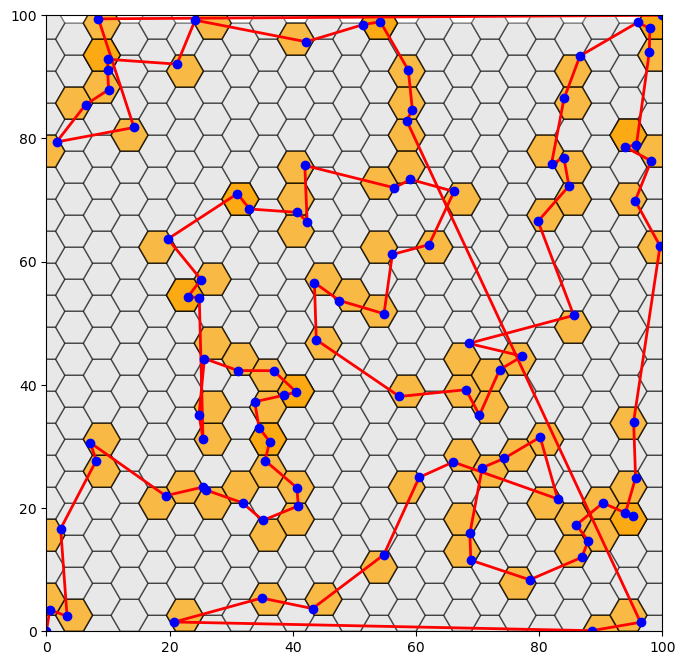

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from scipy.spatial import distance

def hexagon_center_grid(a, b, d):
    """
    生成覆盖地图的六边形网格中心点坐标列表
    """
    hex_centers = []
    row = 0
    y_offset = np.sqrt(3) * d / 2
    while row * y_offset < b:
        col = 0
        x_offset = 3 * d
        while col * x_offset < a:
            x = col * x_offset + (0 if row % 2 == 0 else 1.5 * d)
            y = row * y_offset
            if x <= 1.4*a and y <= 1.4*b:
                hex_centers.append((x, y))
            col += 1
        row += 1
    return hex_centers

def draw_hexagons(ax, centers, d, color='lightgrey', edgecolor='black'):
    """
    在地图上绘制六边形网格
    """
    for center in centers:
        hexagon = patches.RegularPolygon(center, numVertices=6, radius=d, orientation=np.radians(30),
                                         edgecolor=edgecolor, facecolor=color, alpha=0.5)
        ax.add_patch(hexagon)

def generate_random_nodes(a, b, n):
    """
    在地图上随机生成n个节点
    """
    return [(random.uniform(0, a), random.uniform(0, b)) for _ in range(n)]

def highlight_hexagons_with_nodes(ax, centers, nodes, d):
    """
    突出显示包含节点的六边形区域
    """
    for node in nodes:
        closest_center = min(centers, key=lambda c: distance.euclidean(c, node))
        hexagon = patches.RegularPolygon(closest_center, numVertices=6, radius=d, orientation=np.radians(30),
                                         edgecolor='black', facecolor='orange', alpha=0.7)
        ax.add_patch(hexagon)

def plan_path(a, b, n, d, node_list, hex_centers):
    """
    规划从(0,0)到(a,b)经过所有节点的最短路径
    """
    path = []
    current_position = (0, 0)
    path.append(current_position)

    unvisited_nodes = node_list[:]

    while unvisited_nodes:
        closest_node = min(unvisited_nodes, key=lambda n: distance.euclidean(current_position, n))
        path.append(closest_node)
        unvisited_nodes.remove(closest_node)
        current_position = closest_node

    path.append((a, b))
    return path

def draw_path(ax, path):
    """
    在地图上绘制路径
    """
    x_vals, y_vals = zip(*path)
    ax.plot(x_vals, y_vals, 'r-', linewidth=2)
    ax.plot(x_vals, y_vals, 'bo')  # 绘制路径上的点

def main():
    a, b = 100, 100  # 地图尺寸
    n = 100  # 节点数
    d = 3   # 六边形边长

    hex_centers = hexagon_center_grid(a, b, d)
    nodes = generate_random_nodes(a, b, n)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(0, a)
    ax.set_ylim(0, b)
    ax.set_aspect('equal')

    # 绘制六边形网格
    draw_hexagons(ax, hex_centers, d)

    # 突出显示包含节点的六边形
    highlight_hexagons_with_nodes(ax, hex_centers, nodes, d)

    # 规划路径
    path = plan_path(a, b, n, d, nodes, hex_centers)

    # 绘制路径
    draw_path(ax, path)

    plt.show()

if __name__ == "__main__":
    main()


In [4]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

def hex_distance(p1, p2):
    """Calculate the distance between two hexagons in a hexagonal grid."""
    return max(abs(p1[0] - p2[0]), abs(p1[1] - p2[1]), abs(p1[0] + p1[1] - p2[0] - p2[1]))

def generate_hexagonal_grid(a, b, d):
    """Generate the centers of hexagons that cover the map."""
    hex_centers = []
    dx = 3/2 * d
    dy = np.sqrt(3) * d

    for i in range(int(b // dy) + 1):
        for j in range(int(a // dx) + 1):
            cx = j * dx
            cy = i * dy if j % 2 == 0 else i * dy + dy / 2
            hex_centers.append((cx, cy))
    return hex_centers

def find_closest_hexagon(point, hex_centers):
    """Find the closest hexagon center to a given point."""
    return min(hex_centers, key=lambda hex_center: np.hypot(point[0] - hex_center[0], point[1] - hex_center[1]))

def tsp_path_planning(a, b, n, d, nodes):
    """Plan the shortest path that visits all nodes and returns to the start."""
    hex_centers = generate_hexagonal_grid(a, b, d)
    node_hex_centers = [find_closest_hexagon(node, hex_centers) for node in nodes]

    # Create a graph where nodes are hex centers and edges are distances between them
    G = nx.Graph()
    for i, hex1 in enumerate(node_hex_centers):
        for j, hex2 in enumerate(node_hex_centers):
            if i != j:
                G.add_edge(hex1, hex2, weight=hex_distance(hex1, hex2))

    # Find the shortest path using the TSP algorithm
    tsp_path = nx.approximation.traveling_salesman_problem(G, cycle=True)
    return tsp_path, hex_centers

def draw_hexagon(ax, center, d, color='lightgrey'):
    """Draw a single hexagon."""
    hexagon = patches.RegularPolygon(center, numVertices=6, radius=d, orientation=np.radians(30),
                                     edgecolor='black', facecolor=color)
    ax.add_patch(hexagon)

def draw_tsp_path(a, b, d, tsp_path, hex_centers, nodes):
    """Draw the hexagonal grid, nodes, and the TSP path."""
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_xlim(0, a)
    ax.set_ylim(0, b)

    # Draw hexagonal grid
    for center in hex_centers:
        draw_hexagon(ax, center, d)

    # Highlight hexagons with nodes
    for node_hex in tsp_path:
        draw_hexagon(ax, node_hex, d, color='yellow')

    # Draw nodes
    for node in nodes:
        ax.plot(node[0], node[1], 'ro')

    # Draw path
    for i in range(len(tsp_path) - 1):
        x1, y1 = tsp_path[i]
        x2, y2 = tsp_path[i + 1]
        ax.plot([x1, x2], [y1, y2], 'b-')

    plt.show()

def main(a, b, n, d):
    # Generate n random nodes
    nodes = [(random.uniform(0, a), random.uniform(0, b)) for _ in range(n)]

    # Perform path planning
    tsp_path, hex_centers = tsp_path_planning(a, b, n, d, nodes)

    # Draw the result
    draw_tsp_path(a, b, d, tsp_path, hex_centers, nodes)

# Example parameters
if __name__ == "__main__":
    a = 100
    b = 100
    n = 100
    d = 5

    main(a, b, n, d)


ModuleNotFoundError: No module named 'numpy'

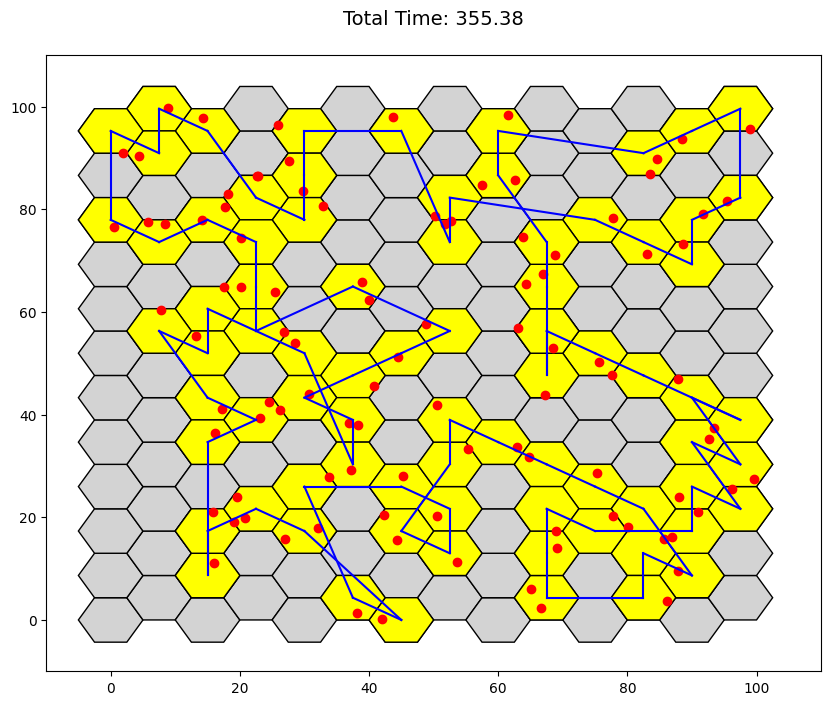

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

def hex_distance(p1, p2):
    """Calculate the distance between two hexagons in a hexagonal grid."""
    return max(abs(p1[0] - p2[0]), abs(p1[1] - p2[1]), abs(p1[0] + p1[1] - p2[0] - p2[1]))

def generate_hexagonal_grid(a, b, d):
    """Generate the centers of hexagons that cover the map."""
    hex_centers = []
    dx = 3/2 * d
    dy = np.sqrt(3) * d

    for i in range(int(b // dy) + 1):
        for j in range(int(a // dx) + 1):
            cx = j * dx
            cy = i * dy if j % 2 == 0 else i * dy + dy / 2
            hex_centers.append((cx, cy))
    return hex_centers

def find_closest_hexagon(point, hex_centers):
    """Find the closest hexagon center to a given point."""
    return min(hex_centers, key=lambda hex_center: np.hypot(point[0] - hex_center[0], point[1] - hex_center[1]))

def tsp_path_planning(a, b, n, d, nodes, speeds):
    """Plan the shortest path that visits all nodes and returns to the start."""
    hex_centers = generate_hexagonal_grid(a, b, d)
    node_hex_centers = [find_closest_hexagon(node, hex_centers) for node in nodes]

    # Create a graph where nodes are hex centers and edges are distances between them
    G = nx.Graph()
    for i, hex1 in enumerate(node_hex_centers):
        for j, hex2 in enumerate(node_hex_centers):
            if i != j:
                G.add_edge(hex1, hex2, weight=hex_distance(hex1, hex2))

    # Find the shortest path using the TSP algorithm
    tsp_path = nx.approximation.traveling_salesman_problem(G, cycle=True)
    
    # Calculate total time based on variable speeds
    total_time = 0
    for i in range(len(tsp_path) - 1):
        distance = hex_distance(tsp_path[i], tsp_path[i + 1])
        speed = speeds[i]
        total_time += distance / speed
    
    return tsp_path, hex_centers, total_time

def draw_hexagon(ax, center, d, color='lightgrey'):
    """Draw a single hexagon."""
    hexagon = patches.RegularPolygon(center, numVertices=6, radius=d, orientation=np.radians(30),
                                     edgecolor='black', facecolor=color)
    ax.add_patch(hexagon)

def draw_tsp_path(a, b, d, tsp_path, hex_centers, nodes, total_time):
    """Draw the hexagonal grid, nodes, and the TSP path."""
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_xlim(-10, a+10)
    ax.set_ylim(-10, b+10)

    # Draw hexagonal grid
    for center in hex_centers:
        draw_hexagon(ax, center, d)

    # Highlight hexagons with nodes
    for node_hex in tsp_path:
        draw_hexagon(ax, node_hex, d, color='yellow')

    # Draw nodes
    for node in nodes:
        ax.plot(node[0], node[1], 'ro')

    # Draw path
    for i in range(len(tsp_path) - 1):
        x1, y1 = tsp_path[i]
        x2, y2 = tsp_path[i + 1]
        ax.plot([x1, x2], [y1, y2], 'b-')
    
    # Display total time as an icon or label
    ax.text(0.5, 1.05, f"Total Time: {total_time:.2f}", transform=ax.transAxes, ha="center", fontsize=14)

    plt.show()

def main(a, b, n, d):
    # Generate n random nodes
    nodes = [(random.uniform(0, a), random.uniform(0, b)) for _ in range(n)]
    
    # Generate random speeds for each segment
    speeds = [random.uniform(1, 5) for _ in range(n)]

    # Perform path planning
    tsp_path, hex_centers, total_time = tsp_path_planning(a, b, n, d, nodes, speeds)

    # Draw the result
    draw_tsp_path(a, b, d, tsp_path, hex_centers, nodes, total_time)

# Example parameters
if __name__ == "__main__":
    a = 100
    b = 100
    n = 100
    d = 5

    main(a, b, n, d)


```txt
在一片大小为a*b的二维空间中，随机分布着n个点，以坐标原点为中心建立蜂巢网格，六边形边长为d。一个通信范围为d的无人机从原点出发，依次到达每个含有节点的网格的中心，无人机每次仅能从一个网格中心到达此时相邻的网格中心。

功能解耦：主要划分为四个模块：
1.随机生成模块，以不同的方式随机生成多种节点分布。
2.算法模块，依据参数对列表进行排序。
3.评估模块，对得到的结果尽心评估。
4.GUI模块，绘制六边形栅格地图并且对评估结果可视化。

其中GUI模块与其他三个模块隔离，不能阻塞结果的产生，在前三个模块运行结束之后，将结果存入xml文件中，GUI模块启动后读取xml文件来进行展示。
上述三个模块需要封装成库，使用独立的python脚本进行调用，可以重复运算多次，并且对各个模块进行替换。

```

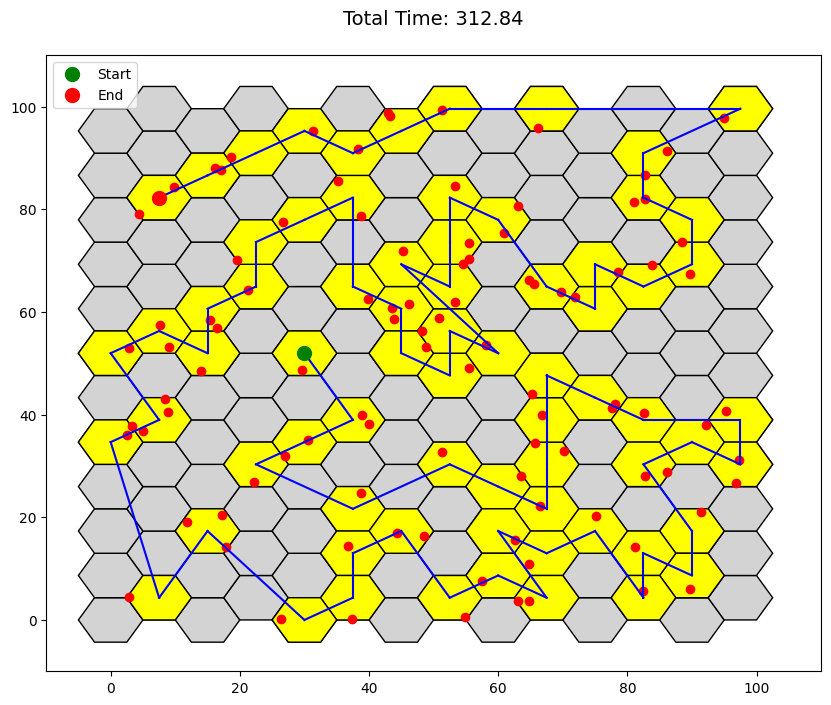

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

def hex_distance(p1, p2):
    """Calculate the distance between two hexagons in a hexagonal grid."""
    return max(abs(p1[0] - p2[0]), abs(p1[1] - p2[1]), abs(p1[0] + p1[1] - p2[0] - p2[1]))

def generate_hexagonal_grid(a, b, d):
    """Generate the centers of hexagons that cover the map."""
    hex_centers = []
    dx = 3/2 * d
    dy = np.sqrt(3) * d

    for i in range(int(b // dy) + 1):
        for j in range(int(a // dx) + 1):
            cx = j * dx
            cy = i * dy if j % 2 == 0 else i * dy + dy / 2
            hex_centers.append((cx, cy))
    return hex_centers

def find_closest_hexagon(point, hex_centers):
    """Find the closest hexagon center to a given point."""
    return min(hex_centers, key=lambda hex_center: np.hypot(point[0] - hex_center[0], point[1] - hex_center[1]))

def tsp_path_planning(a, b, n, d, nodes, speeds):
    """Plan the path that visits all nodes, starting from the bottom right and ending at the top left."""
    hex_centers = generate_hexagonal_grid(a, b, d)
    node_hex_centers = [find_closest_hexagon(node, hex_centers) for node in nodes]

    # Find start (bottom right) and end (top left) points
    start = max(node_hex_centers, key=lambda p: p[0] + p[1])
    end = min(node_hex_centers, key=lambda p: p[0] + p[1])

    # Create a graph where nodes are hex centers and edges are distances between them
    G = nx.Graph()
    for i, hex1 in enumerate(node_hex_centers):
        for j, hex2 in enumerate(node_hex_centers):
            if i != j:
                G.add_edge(hex1, hex2, weight=hex_distance(hex1, hex2))

    # Find the shortest path using the TSP algorithm, starting and ending at specific points
    path = nx.approximation.traveling_salesman_problem(G, cycle=False, nodes=[start] + [n for n in node_hex_centers if n != start and n != end] + [end])

    # Calculate total time based on variable speeds
    total_time = 0
    for i in range(len(path) - 1):
        distance = hex_distance(path[i], path[i + 1])
        speed = speeds[i]
        total_time += distance / speed

    return path, hex_centers, total_time

def draw_hexagon(ax, center, d, color='lightgrey'):
    """Draw a single hexagon."""
    hexagon = patches.RegularPolygon(center, numVertices=6, radius=d, orientation=np.radians(30),
                                     edgecolor='black', facecolor=color)
    ax.add_patch(hexagon)

def draw_tsp_path(a, b, d, path, hex_centers, nodes, total_time):
    """Draw the hexagonal grid, nodes, and the path."""
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_xlim(-10, a+10)
    ax.set_ylim(-10, b+10)

    # Draw hexagonal grid
    for center in hex_centers:
        draw_hexagon(ax, center, d)

    # Highlight hexagons with nodes
    for node_hex in path:
        draw_hexagon(ax, node_hex, d, color='yellow')

    # Draw nodes
    for node in nodes:
        ax.plot(node[0], node[1], 'ro')

    # Draw path
    for i in range(len(path) - 1):
        x1, y1 = path[i]
        x2, y2 = path[i + 1]
        ax.plot([x1, x2], [y1, y2], 'b-')

    # Mark start and end points
    start = path[0]
    end = path[-1]
    ax.plot(start[0], start[1], 'go', markersize=10, label='Start')
    ax.plot(end[0], end[1], 'ro', markersize=10, label='End')

    # Display total time as an icon or label
    ax.text(0.5, 1.05, f"Total Time: {total_time:.2f}", transform=ax.transAxes, ha="center", fontsize=14)

    plt.legend()
    plt.show()

def main(a, b, n, d):
    # Generate n random nodes
    nodes = [(random.uniform(0, a), random.uniform(0, b)) for _ in range(n)]

    # Generate random speeds for each segment
    speeds = [random.uniform(1, 5) for _ in range(n)]

    # Perform path planning
    path, hex_centers, total_time = tsp_path_planning(a, b, n, d, nodes, speeds)

    # Draw the result
    draw_tsp_path(a, b, d, path, hex_centers, nodes, total_time)

# Example parameters
if __name__ == "__main__":
    a = 100  # Width of the area
    b = 100  # Height of the area
    n = 100   # Number of nodes
    d = 5    # Radius of hexagons

    main(a, b, n, d)

### 良好的算法架构可以为后期科研工作提供很大的便利。在此我提出两种节点规划算法的架构，希望能够为后续的研究工作提供一些参考。    

# 项目概览
本项目包括算法、GUI与evaluate三个模块。

GUI界面支持多种算法联合评估，一键生成评估报告。

## Kmeans
进行聚类后以簇的均值代表簇，进行最近邻排序，然后根据相邻最短距离规划簇与簇之间的连接方案

## NNA
最近邻算法

## AOP-simple
质朴的蚁群算法

## AOP-multiprogress
多核并行蚁群算法（已弃用，python多线程效率太低，改用go语言，但是go语言gui界面难以实现）


# 最近邻算法（NNA）
考虑每个距离每个节点最近的节点

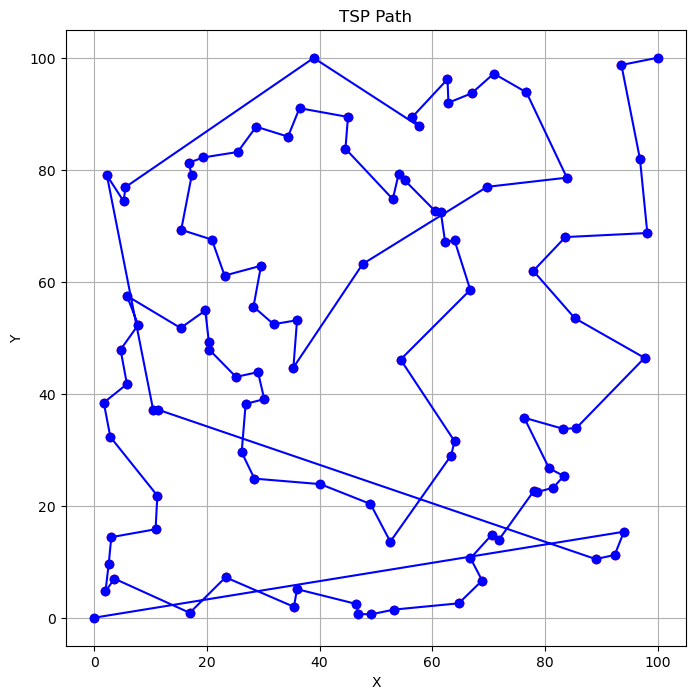

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean

# 生成随机节点
def generate_random_nodes(num_nodes, x_max, y_max):
    nodes = np.random.rand(num_nodes, 2)
    nodes[:, 0] *= x_max
    nodes[:, 1] *= y_max
    return nodes

# 计算两点之间的欧几里得距离
def calculate_distance(a, b):
    return euclidean(a, b)

# 使用最近邻算法解决TSP问题
def nearest_neighbor_tsp(nodes):
    path = []
    num_nodes = len(nodes)
    visited = [False] * num_nodes
    
    # 起点
    current = np.array([100.0, 100.0])
    path.append(current)
    
    for _ in range(num_nodes):
        min_distance = float('inf')
        nearest_node_index = -1
        
        for i in range(num_nodes):
            if not visited[i]:
                distance = calculate_distance(current, nodes[i])
                if distance < min_distance:
                    min_distance = distance
                    nearest_node_index = i
        
        visited[nearest_node_index] = True
        current = nodes[nearest_node_index]
        path.append(current)
    
    # 终点
    path.append(np.array([0.0, 0.0]))
    
    return np.array(path)

# 绘制路径
def draw_path(path):
    plt.figure(figsize=(8, 8))
    plt.plot(path[:, 0], path[:, 1], marker='o', linestyle='-', color='b')
    plt.scatter(path[:, 0], path[:, 1], color='r')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('TSP Path')
    plt.grid(True)
    plt.show()

def main():
    num_nodes = 100
    x_max = 100.0
    y_max = 100.0
    
    # 生成随机节点
    nodes = generate_random_nodes(num_nodes, x_max, y_max)
    
    # 计算最近邻路径
    path = nearest_neighbor_tsp(nodes)
    
    # 绘制路径
    draw_path(path)

if __name__ == "__main__":
    main()

#### 除了这种方法外，还有很多很棒的方法，比如蚁群算法、遗传算法等等，这些方法都可以用来解决TSP问题。但是当我开始考虑将速度与转弯开销纳入变量中时，问题的解析开始变得棘手。为了保证问题的完整性，我考虑了多种参数大小的范围，当参数数量级过大时，距离矩阵体积过大，运算开销巨大。并且，常规的欧几里得距离不能满足求解需求，因此在进行运算的过程中，需要同时加入多种距离方法，比如曼哈顿距离，这对于增加路径的曲率有巨大帮助。

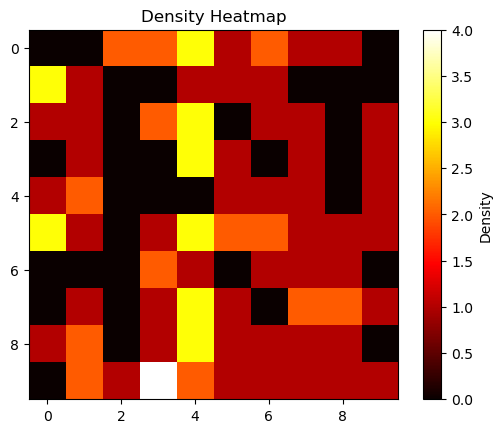

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1. 生成随机点
points = np.random.rand(100, 2) * 100  # 生成100个随机点，范围在[0, 100)之间

# 2. 构建网格
grid_size = 10
density = np.zeros((grid_size, grid_size))

# 3. 计算密度
for point in points:
    x_idx = int(point[0] // (100 / grid_size))
    y_idx = int(point[1] // (100 / grid_size))
    density[x_idx, y_idx] += 1

# 4. 生成密度图
plt.imshow(density, cmap='hot', interpolation='nearest')
plt.colorbar(label='Density')
plt.title('Density Heatmap')
plt.show()


### 正态分布法（mp）
这里还有一种更好的方法，由于点的分布不可预测，因此整张图的尺寸也同样不可预测，因此可以借用正态分布函数，计算出一张热力图并且离散化，


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 设置地图尺寸和随机点的数量
map_size = 1000
num_points = 100000

# 随机生成点的坐标
points = np.random.rand(num_points, 2) * map_size

# 创建一个格子图，每个格子初始化为0
grid = np.zeros((map_size, map_size))

# 标准差，用于正态分布函数
sigma = 50

# 计算每个格子的值
for x in range(map_size):
    for y in range(map_size):
        distances = np.sqrt((points[:, 0] - x)**2 + (points[:, 1] - y)**2)
        grid[x, y] = np.sum(norm.pdf(distances, scale=sigma))

# 使用热力图显示结果
plt.figure(figsize=(10, 10))
plt.imshow(grid, cmap='hot', origin='lower')
plt.colorbar()
plt.title("Heatmap of 100,000 Points in a 1000x1000 Grid")
plt.show()

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean


# 生成随机节点
def generate_random_nodes(num_nodes, x_max, y_max):
    nodes = np.random.rand(num_nodes, 2)
    nodes[:, 0] *= x_max
    nodes[:, 1] *= y_max
    return nodes


# 计算两点之间的欧几里得距离
def calculate_distance(a, b):
    return euclidean(a, b)


# 使用最近邻算法解决TSP问题
def nearest_neighbor_tsp(nodes):
    path = []
    num_nodes = len(nodes)
    visited = [False] * num_nodes

    # 起点
    current = np.array([100.0, 100.0])
    path.append(current)

    for _ in range(num_nodes):
        min_distance = float('inf')
        nearest_node_index = -1

        for i in range(num_nodes):
            if not visited[i]:
                distance = calculate_distance(current, nodes[i])
                if distance < min_distance:
                    min_distance = distance
                    nearest_node_index = i

        visited[nearest_node_index] = True
        current = nodes[nearest_node_index]
        path.append(current)

    # 终点
    path.append(np.array([0.0, 0.0]))

    return np.array(path)


# 绘制路径
def draw_path(path):
    plt.figure(figsize=(8, 8))
    plt.plot(path[:, 0], path[:, 1], marker='o', linestyle='-', color='b')
    plt.scatter(path[:, 0], path[:, 1], color='r')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('TSP Path')
    plt.grid(True)
    plt.show()


def main():
    num_nodes = 1000
    
    x_max = 100.0
    y_max = 100.0

    # 生成随机节点
    nodes = generate_random_nodes(num_nodes, x_max, y_max)

    # 计算最近邻路径
    path = nearest_neighbor_tsp(nodes)

    # 绘制路径
    draw_path(path)


if __name__ == "__main__":
    main()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

# 生成随机节点
def generate_random_nodes(num_nodes, x_max, y_max):
    nodes = np.random.rand(num_nodes, 2)
    nodes[:, 0] *= x_max
    nodes[:, 1] *= y_max
    return nodes

# 计算两点之间的欧几里得距离
def calculate_distance_matrix(nodes):
    num_nodes = len(nodes)
    dist_matrix = np.zeros((num_nodes, num_nodes))
    for i in range(num_nodes):
        for j in range(num_nodes):
            dist_matrix[i, j] = np.linalg.norm(nodes[i] - nodes[j])
    return dist_matrix

# 动态规划解决 TSP
def tsp_dynamic_programming(dist_matrix):
    num_nodes = len(dist_matrix)
    dp = np.full((1 << num_nodes, num_nodes), np.inf)
    dp[1][0] = 0
    
    for mask in range(1 << num_nodes):
        for i in range(num_nodes):
            if not (mask & (1 << i)):
                continue
            for j in range(num_nodes):
                if mask & (1 << j) and i != j:
                    dp[mask][i] = min(dp[mask][i], dp[mask ^ (1 << i)][j] + dist_matrix[j][i])
    
    full_mask = (1 << num_nodes) - 1
    best_path_cost = min(dp[full_mask][i] + dist_matrix[i][0] for i in range(1, num_nodes))
    return best_path_cost, dp

# 反向追踪路径
def get_path(dp, dist_matrix):
    num_nodes = len(dist_matrix)
    mask = (1 << num_nodes) - 1
    last_index = np.argmin([dp[mask][i] + dist_matrix[i][0] for i in range(1, num_nodes)]) + 1
    
    path = [0]
    while mask:
        path.append(last_index)
        mask, last_index = mask ^ (1 << last_index), np.argmin([dp[mask ^ (1 << last_index)][j] + dist_matrix[j][last_index] for j in range(num_nodes) if mask & (1 << j)])
    return path[::-1]

# 绘制路径
def draw_path(nodes, path):
    plt.figure(figsize=(8, 8))
    plt.plot(nodes[path, 0], nodes[path, 1], marker='o', linestyle='-', color='b')
    plt.scatter(nodes[:, 0], nodes[:, 1], color='r')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('TSP Path')
    plt.grid(True)
    plt.show()

def main():
    num_nodes = 10
    x_max = 100.0
    y_max = 100.0
    
    # 生成随机节点
    nodes = generate_random_nodes(num_nodes, x_max, y_max)
    
    # 计算距离矩阵
    dist_matrix = calculate_distance_matrix(nodes)
    
    # 计算最短路径和最小路径代价
    best_path_cost, dp = tsp_dynamic_programming(dist_matrix)
    
    # 反向追踪路径
    path = get_path(dp, dist_matrix)
    
    # 打印最短路径和代价
    print(f"The shortest path cost is: {best_path_cost}")
    print(f"The path is: {path}")
    
    # 绘制路径
    draw_path(nodes, path)

if __name__ == "__main__":
    main()


读取xml文件中的变量

In [ ]:
import os
import xml.etree.ElementTree as ET

# 获取当前文件夹路径
current_folder = os.getcwd()

# XML文件路径
xml_file = os.path.join(current_folder, 'variables.xml')

# 解析XML文件
tree = ET.parse(xml_file)
root = tree.getroot()

# 遍历所有variable节点
variables = {}
for variable in root.findall('.//variable'):
    name = variable.get('name')
    value = variable.text
    variables[name] = value

# 打印所有变量及其值
for name, value in variables.items():
    print(f'{name}: {value}')

var1: value1
var2: value2
var3: value3


```text
在大小为a*b的地图中随机生成n个节点,节点生成时不需要考虑参数d。
将整个地图划分为边长为d的矩形区域，在GUI界面中绘制矩形图以及节点，找到并使用其他颜色绘制含有节点的区域。
路径规划算法应以矩形为单位，旅行商从(0,0)出发，到(a,b)结束。每次行动从当前矩形中心前往相邻的八个矩形中心之一，每个节点可以被访问多次，使路径最短。若节点之间无法相互连接，可以启用未被占据的节点。
将算法模块化为一个函数，输入参数包括：(地图长宽a、b，节点个数n，矩形边长d)，以及节点列表，输出路径列表。
在得到路径列表后，生成路径并绘制。
```

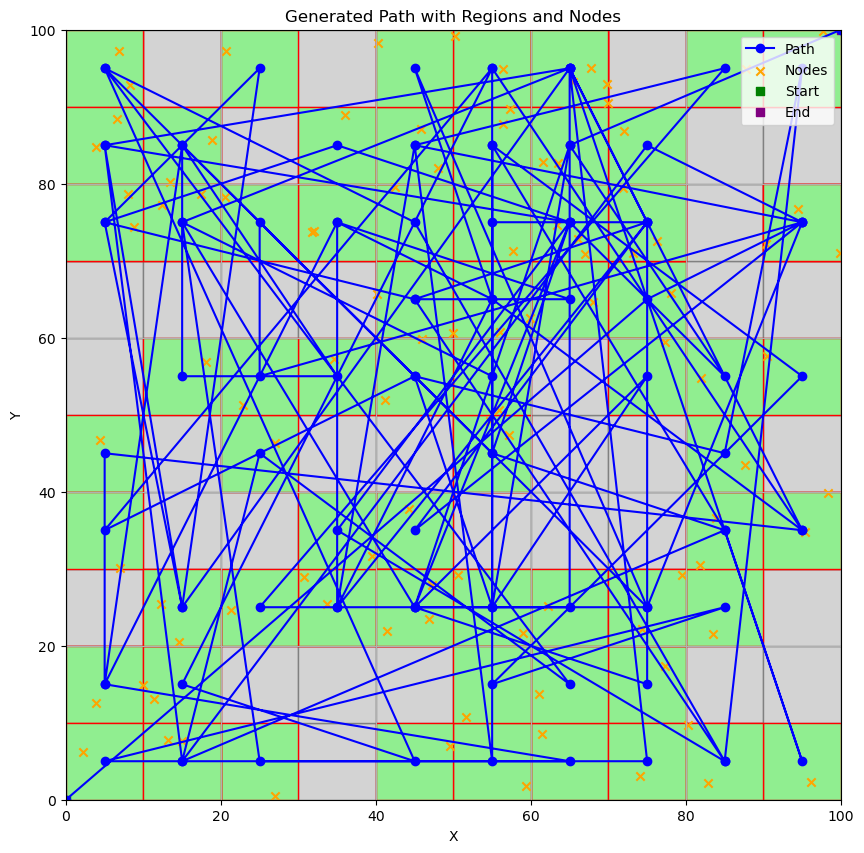

Coordinates: [(0, 0), (75.0, 65.0), (95.0, 75.0), (45.0, 35.0), (75.0, 75.0), (65.0, 95.0), (5.0, 85.0), (65.0, 75.0), (45.0, 25.0), (75.0, 15.0), (75.0, 75.0), (45.0, 65.0), (65.0, 65.0), (35.0, 75.0), (5.0, 15.0), (65.0, 5.0), (25.0, 5.0), (15.0, 75.0), (45.0, 25.0), (75.0, 55.0), (55.0, 25.0), (55.0, 75.0), (75.0, 75.0), (35.0, 25.0), (35.0, 75.0), (55.0, 65.0), (35.0, 25.0), (45.0, 85.0), (95.0, 75.0), (75.0, 85.0), (15.0, 5.0), (25.0, 45.0), (65.0, 15.0), (5.0, 95.0), (45.0, 75.0), (85.0, 5.0), (45.0, 65.0), (5.0, 75.0), (35.0, 85.0), (65.0, 75.0), (55.0, 45.0), (55.0, 85.0), (55.0, 5.0), (45.0, 85.0), (85.0, 95.0), (25.0, 25.0), (65.0, 25.0), (65.0, 95.0), (95.0, 5.0), (85.0, 35.0), (55.0, 45.0), (15.0, 85.0), (15.0, 55.0), (35.0, 55.0), (15.0, 85.0), (5.0, 15.0), (5.0, 45.0), (95.0, 35.0), (55.0, 95.0), (5.0, 35.0), (45.0, 55.0), (55.0, 25.0), (65.0, 85.0), (45.0, 25.0), (75.0, 25.0), (5.0, 95.0), (45.0, 5.0), (15.0, 15.0), (55.0, 95.0), (55.0, 55.0), (15.0, 75.0), (65.0, 95.0),

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.spatial import distance_matrix
from heapq import heappop, heappush

def generate_nodes(a, b, n):
    """在地图内随机生成n个节点"""
    return [(np.random.uniform(0, a), np.random.uniform(0, b)) for _ in range(n)]

def divide_map_into_regions(a, b, d):
    """将地图划分为边长为d的矩形区域"""
    regions = []
    x_splits = int(np.ceil(a / d))
    y_splits = int(np.ceil(b / d))
    for i in range(x_splits):
        for j in range(y_splits):
            x1, y1 = i * d, j * d
            x2, y2 = min(x1 + d, a), min(y1 + d, b)
            region_center = ((x1 + x2) / 2, (y1 + y2) / 2)
            regions.append(((x1, y1, x2, y2), region_center))
    return regions

def find_regions_with_nodes(regions, nodes):
    """找到包含节点的区域并标记"""
    regions_with_nodes = []
    for node in nodes:
        for region, center in regions:
            x1, y1, x2, y2 = region
            if x1 <= node[0] < x2 and y1 <= node[1] < y2:
                regions_with_nodes.append((region, center))
                break
    return regions_with_nodes

def create_adjacency_matrix(region_centers, d):
    """创建相邻矩形的邻接矩阵"""
    n = len(region_centers)
    adj_matrix = np.zeros((n, n))
    distances = distance_matrix(region_centers, region_centers)
    for i in range(n):
        for j in range(n):
            if i != j:
                dist = np.linalg.norm(np.array(region_centers[i]) - np.array(region_centers[j]))
                if dist <= d * np.sqrt(2):  # Considering diagonal neighbors
                    adj_matrix[i, j] = dist
    return adj_matrix

def greedy_path_planning(start, region_centers, adj_matrix):
    """贪心算法找到最短路径，优先选择最近的矩形中心"""
    n = len(region_centers)
    path = [start]
    visited = set()
    visited.add(start)
    current_index = 0
    
    while len(visited) < n:
        min_dist = np.inf
        next_index = None
        
        for i in range(n):
            if i not in visited and adj_matrix[current_index][i] < min_dist:
                min_dist = adj_matrix[current_index][i]
                next_index = i
        
        if next_index is not None:
            path.append(next_index)
            visited.add(next_index)
            current_index = next_index
        else:
            break
    
    return path

def plot_path(coordinates, regions, regions_with_nodes, nodes, a, b, d):
    """绘制路径、区域、节点"""
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # 绘制矩形区域
    for region, _ in regions:
        x1, y1, x2, y2 = region
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='gray', facecolor='lightgray')
        ax.add_patch(rect)
    
    # 标记含有节点的矩形区域
    for region, _ in regions_with_nodes:
        x1, y1, x2, y2 = region
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='red', facecolor='lightgreen')
        ax.add_patch(rect)
    
    # 绘制路径
    x_coords, y_coords = zip(*coordinates)
    ax.plot(x_coords, y_coords, marker='o', color='blue', label="Path")
    
    # 绘制节点
    node_x, node_y = zip(*nodes)
    ax.scatter(node_x, node_y, color='orange', marker='x', label="Nodes")
    
    # 绘制起点和终点
    ax.scatter(0, 0, color='green', marker='s', label="Start")
    ax.scatter(a, b, color='purple', marker='s', label="End")
    
    ax.set_xlim(0, a)
    ax.set_ylim(0, b)
    ax.set_title("Generated Path with Regions and Nodes")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.legend()
    ax.grid(True)
    plt.show()

def main(a, b, n, d):
    """主函数，执行各个步骤"""
    # Step 1: Generate nodes
    nodes = generate_nodes(a, b, n)
    
    # Step 2: Divide the map into rectangular regions
    regions = divide_map_into_regions(a, b, d)
    
    # Step 3: Find regions that contain nodes and their centers
    regions_with_nodes = find_regions_with_nodes(regions, nodes)
    region_centers = [center for _, center in regions_with_nodes]
    
    # Include the start and end points as potential centers
    start = (0, 0)
    end = (a, b)
    region_centers = [start] + region_centers + [end]
    
    # Create adjacency matrix for region centers
    adj_matrix = create_adjacency_matrix(region_centers, d)
    
    # Find the path through region centers using greedy approach
    start_index = 0
    end_index = len(region_centers) - 1
    path_indices = greedy_path_planning(start_index, region_centers, adj_matrix)
    
    # Convert path indices to coordinates
    path_coordinates = [region_centers[i] for i in path_indices]
    
    # Step 5: Plot the path, regions, and nodes
    plot_path(path_coordinates, regions, regions_with_nodes, nodes, a, b, d)
    
    return path_coordinates

# Example usage
a = 100
b = 100
n = 100
d = 10.0
coordinates = main(a, b, n, d)

print("Coordinates:", coordinates)


```text
请使用python解决一个旅行商问题。解耦算法与GUI绘制函数，先进行路径规划在进行绘图。
在大小为a*b的地图中随机生成n个节点,节点生成时不需要考虑参数d。
将整个地图划分为边长为d的矩形区域，在GUI界面中绘制矩形图以及节点，找到并使用其他颜色绘制含有节点的区域。
路径规划算法应以矩形为单位，旅行商从(0,0)出发，到(a,b)结束。每次行动从当前矩形中心前往相邻的八个矩形中心之一，每个节点可以被访问多次，使路径最短。优先前往相邻的节点。
将算法模块化为一个函数，输入参数包括：(地图长宽a、b，节点个数n，矩形边长d)，以及节点列表，输出路径列表。
在得到路径列表后，生成路径并绘制。
```

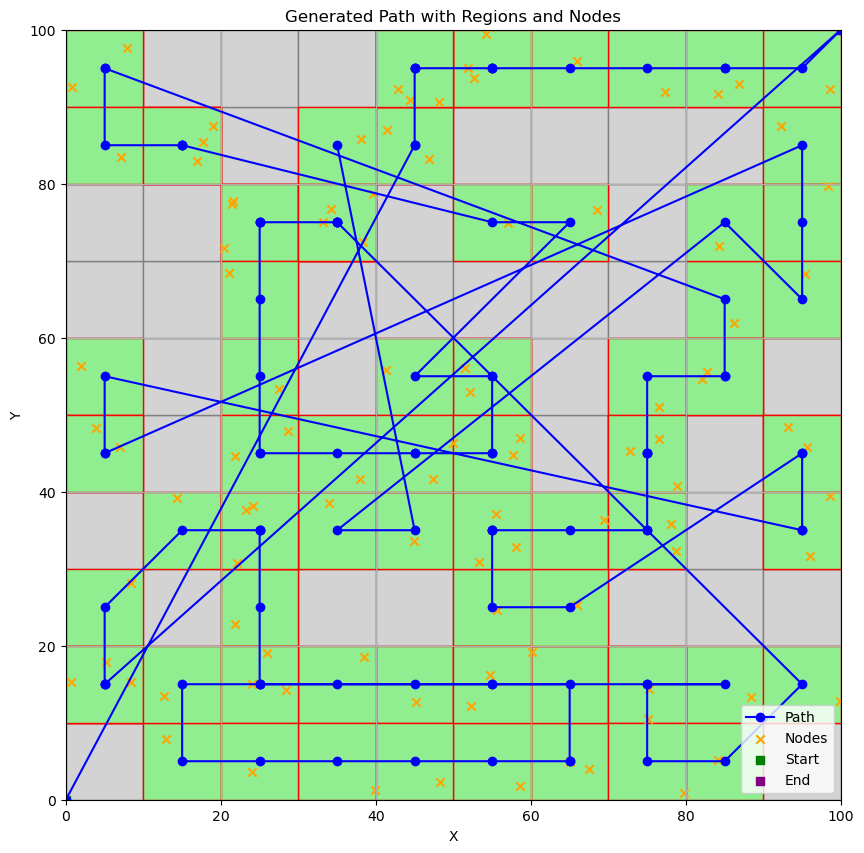

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.spatial import distance_matrix

def generate_nodes(a, b, n):
    """在地图内随机生成n个节点"""
    return [(np.random.uniform(0, a), np.random.uniform(0, b)) for _ in range(n)]

def divide_map_into_regions(a, b, d):
    """将地图划分为边长为d的矩形区域"""
    regions = []
    x_splits = int(np.ceil(a / d))
    y_splits = int(np.ceil(b / d))
    for i in range(x_splits):
        for j in range(y_splits):
            x1, y1 = i * d, j * d
            x2, y2 = min(x1 + d, a), min(y1 + d, b)
            region_center = ((x1 + x2) / 2, (y1 + y2) / 2)
            regions.append(((x1, y1, x2, y2), region_center))
    return regions

def find_regions_with_nodes(regions, nodes):
    """找到包含节点的区域并标记"""
    regions_with_nodes = []
    for node in nodes:
        for region, center in regions:
            x1, y1, x2, y2 = region
            if x1 <= node[0] < x2 and y1 <= node[1] < y2:
                regions_with_nodes.append((region, center))
                break
    return regions_with_nodes

def tsp_path_planning(a, b, n, d, nodes):
    """路径规划算法模块化"""
    regions = divide_map_into_regions(a, b, d)
    regions_with_nodes = find_regions_with_nodes(regions, nodes)
    region_centers = [center for _, center in regions_with_nodes]
    
    # Include the start and end points as potential centers
    start = (0, 0)
    end = (a, b)
    region_centers = [start] + region_centers + [end]
    
    # Create adjacency matrix for region centers
    adj_matrix = create_adjacency_matrix(region_centers, d)
    
    # Solve TSP using optimized greedy approach
    path_indices = prioritized_greedy_path_planning(0, region_centers, adj_matrix, d)
    
    # Convert path indices to coordinates
    path_coordinates = [region_centers[i] for i in path_indices]
    
    return path_coordinates, regions, regions_with_nodes, nodes

def create_adjacency_matrix(region_centers, d):
    """创建相邻矩形的邻接矩阵"""
    n = len(region_centers)
    adj_matrix = np.zeros((n, n))
    distances = distance_matrix(region_centers, region_centers)
    for i in range(n):
        for j in range(n):
            if i != j:
                dist = np.linalg.norm(np.array(region_centers[i]) - np.array(region_centers[j]))
                if dist <= d * np.sqrt(2):  # Considering diagonal neighbors
                    adj_matrix[i, j] = dist
    return adj_matrix

def get_neighbors(index, region_centers, d):
    """获取当前矩形中心的邻居"""
    current_center = region_centers[index]
    neighbors = []
    for i, center in enumerate(region_centers):
        if i != index:
            dist = np.linalg.norm(np.array(current_center) - np.array(center))
            if dist <= d * np.sqrt(2):
                neighbors.append((i, dist))
    return neighbors

def prioritized_greedy_path_planning(start, region_centers, adj_matrix, d):
    """优先前往相邻方格的贪心算法"""
    n = len(region_centers)
    path = [start]
    visited = set()
    visited.add(start)
    current_index = start
    
    while len(visited) < n:
        neighbors = get_neighbors(current_index, region_centers, d)
        next_index = None
        min_dist = np.inf
        
        # 优先选择最近的未访问邻居
        for neighbor, dist in neighbors:
            if neighbor not in visited and dist < min_dist:
                min_dist = dist
                next_index = neighbor
        
        if next_index is None:
            # 如果没有未访问的邻居，则扩展搜索范围
            for i in range(n):
                if i not in visited and adj_matrix[current_index][i] < min_dist:
                    min_dist = adj_matrix[current_index][i]
                    next_index = i
        
        if next_index is not None:
            path.append(next_index)
            visited.add(next_index)
            current_index = next_index
        else:
            break
    
    return path

def plot_path(coordinates, regions, regions_with_nodes, nodes, a, b, d):
    """绘制路径、区域、节点"""
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # 绘制矩形区域
    for region, _ in regions:
        x1, y1, x2, y2 = region
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='gray', facecolor='lightgray')
        ax.add_patch(rect)
    
    # 标记含有节点的矩形区域
    for region, _ in regions_with_nodes:
        x1, y1, x2, y2 = region
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='red', facecolor='lightgreen')
        ax.add_patch(rect)
    
    # 绘制路径
    x_coords, y_coords = zip(*coordinates)
    ax.plot(x_coords, y_coords, marker='o', color='blue', label="Path")
    
    # 绘制节点
    node_x, node_y = zip(*nodes)
    ax.scatter(node_x, node_y, color='orange', marker='x', label="Nodes")
    
    # 绘制起点和终点
    ax.scatter(0, 0, color='green', marker='s', label="Start")
    ax.scatter(a, b, color='purple', marker='s', label="End")
    
    ax.set_xlim(0, a)
    ax.set_ylim(0, b)
    ax.set_title("Generated Path with Regions and Nodes")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.legend()
    ax.grid(True)
    plt.show()

# Example usage
a = 100
b = 100
n = 100
d = 10.0

# Step 1: Generate nodes
nodes = generate_nodes(a, b, n)

# Step 2: Path planning
coordinates, regions, regions_with_nodes, nodes = tsp_path_planning(a, b, n, d, nodes)

# Step 3: Plot the path, regions, and nodes
plot_path(coordinates, regions, regions_with_nodes, nodes, a, b, d)


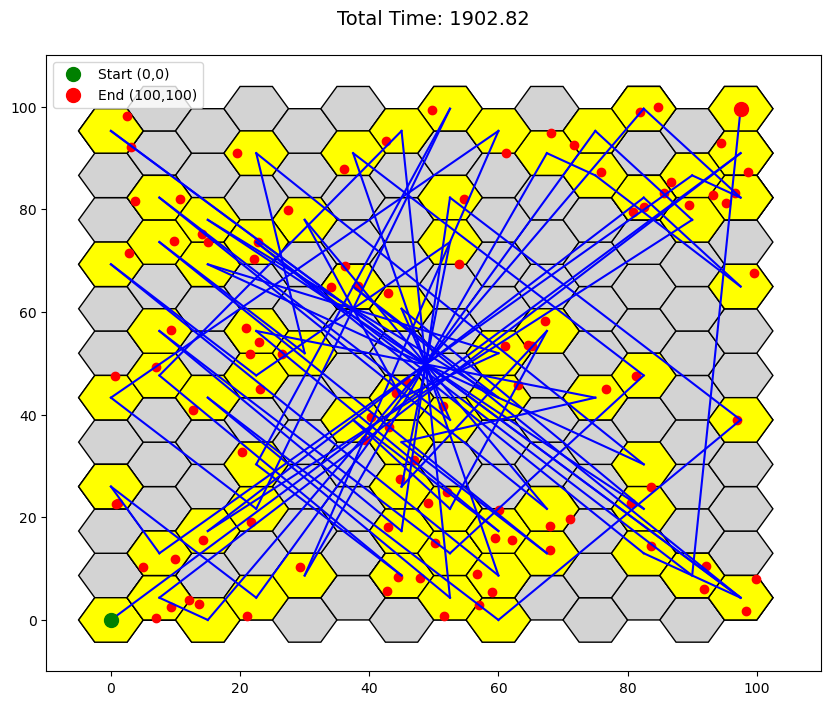

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from functools import lru_cache

def hex_distance(p1, p2):
    """Calculate the distance between two hexagons in a hexagonal grid."""
    return max(abs(p1[0] - p2[0]), abs(p1[1] - p2[1]), abs(p1[0] + p1[1] - p2[0] - p2[1]))

@lru_cache(maxsize=None)
def cached_hex_distance(p1, p2):
    """Cached hex distance function to avoid repeated calculations."""
    return hex_distance(p1, p2)

def generate_hexagonal_grid(a, b, d):
    """Generate the centers of hexagons that cover the map."""
    hex_centers = []
    dx = 3/2 * d
    dy = np.sqrt(3) * d

    for i in range(int(b // dy) + 1):
        for j in range(int(a // dx) + 1):
            cx = j * dx
            cy = i * dy if j % 2 == 0 else i * dy + dy / 2
            hex_centers.append((cx, cy))
    return hex_centers

def find_closest_hexagon(point, hex_centers):
    """Find the closest hexagon center to a given point."""
    return min(hex_centers, key=lambda hex_center: np.hypot(point[0] - hex_center[0], point[1] - hex_center[1]))

def optimized_weighted_distance(node, start, end, start_distance, end_distance):
    """Optimized weighted distance function using cached distances."""
    start_weight = 1 - (cached_hex_distance(start, node) / start_distance)
    end_weight = 1 - (cached_hex_distance(node, end) / end_distance)
    return start_weight * end_weight * (cached_hex_distance(start, node) + cached_hex_distance(node, end))

def sort_nodes_with_reference_optimized(nodes, start, end):
    """Optimized sorting function using precomputed distances."""
    start_distance = cached_hex_distance(start, end)
    end_distance = start_distance  # Symmetry: distance between start and end is the same
    return sorted(nodes, key=lambda node: optimized_weighted_distance(node, start, end, start_distance, end_distance))

def tsp_path_planning(a, b, n, d, nodes, speeds):
    """Plan the path that visits all nodes, starting from (0,0) and ending at (a,b)."""
    hex_centers = generate_hexagonal_grid(a, b, d)
    node_hex_centers = [find_closest_hexagon(node, hex_centers) for node in nodes]

    # Find start (0,0) and end (a,b) points
    start = find_closest_hexagon((0, 0), hex_centers)
    end = find_closest_hexagon((a, b), hex_centers)

    # Ensure start and end are in node_hex_centers
    if start not in node_hex_centers:
        node_hex_centers.insert(0, start)
    if end not in node_hex_centers:
        node_hex_centers.append(end)

    # Sort the middle nodes using the optimized weighted sorting function
    sorted_middle_nodes = sort_nodes_with_reference_optimized(node_hex_centers[1:-1], start, end)

    # Combine start, sorted middle nodes, and end
    path = [start] + sorted_middle_nodes + [end]

    # Calculate total time based on variable speeds
    total_time = 0
    for i in range(len(path) - 1):
        distance = hex_distance(path[i], path[i + 1])
        speed = speeds[i % len(speeds)]  # Use modulo to cycle through speeds if necessary
        total_time += distance / speed

    return path, hex_centers, total_time

def draw_hexagon(ax, center, d, color='lightgrey'):
    """Draw a single hexagon."""
    hexagon = patches.RegularPolygon(center, numVertices=6, radius=d, orientation=np.radians(30),
                                     edgecolor='black', facecolor=color)
    ax.add_patch(hexagon)

def draw_tsp_path(a, b, d, path, hex_centers, nodes, total_time):
    """Draw the hexagonal grid, nodes, and the path."""
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_xlim(-10, a+10)
    ax.set_ylim(-10, b+10)

    # Draw hexagonal grid
    for center in hex_centers:
        draw_hexagon(ax, center, d)

    # Highlight hexagons with nodes
    for node_hex in path:
        draw_hexagon(ax, node_hex, d, color='yellow')

    # Draw nodes
    for node in nodes:
        ax.plot(node[0], node[1], 'ro')

    # Draw path
    for i in range(len(path) - 1):
        x1, y1 = path[i]
        x2, y2 = path[i + 1]
        ax.plot([x1, x2], [y1, y2], 'b-')

    # Mark start and end points
    start = path[0]
    end = path[-1]
    ax.plot(start[0], start[1], 'go', markersize=10, label='Start (0,0)')
    ax.plot(end[0], end[1], 'ro', markersize=10, label='End (100,100)')

    # Display total time as an icon or label
    ax.text(0.5, 1.05, f"Total Time: {total_time:.2f}", transform=ax.transAxes, ha="center", fontsize=14)

    plt.legend()
    plt.show()

def main(a, b, n, d):
    # Generate n random nodes
    nodes = [(random.uniform(0, a), random.uniform(0, b)) for _ in range(n)]

    # Generate random speeds for each segment
    speeds = [random.uniform(1, 5) for _ in range(n)]

    # Perform path planning
    path, hex_centers, total_time = tsp_path_planning(a, b, n, d, nodes, speeds)

    # Draw the result
    draw_tsp_path(a, b, d, path, hex_centers, nodes, total_time)

# Example parameters
if __name__ == "__main__":
    a = 100  # Width of the area
    b = 100  # Height of the area
    n = 100   # Number of nodes
    d = 5    # Radius of hexagons

    main(a, b, n, d)
